# Tutorial : Classifying Orbit5k with Persformer

#### Authors : Nicolas Berkouk and Raphael Reinauer


The Orbit5k dataset consists of 5000 subsets of $[0,1]^2$, each containing $1000$ points. For a given $\rho \in \{2.5, 3.5, 4.0, 4.1,4.3\}$, each subset $S^\rho \subset [0,1]^2 $ is generated randomly according to the following procedure:

1. Start with a uniformly randomly sampled point $(x_0,y_0)\in [0,1]^2$
2. For $n \geq 1$, generate $(x_{n+1},y_{n+1})$ inductively by : 

$$ x_{n+1} = x_{n} + \rho y_n(1-y_n) ~~~\text{mod }1$$
$$ y_{n+1} = y_{n} + \rho x_{n+1}(1-x_{n+1}) ~~~\text{mod }1$$

3. Define $S^\rho := \{(x_i,y_i) \mid i = 0...999 \}$

We generate 1000 orbits for each value of $\rho$. 

The classification problem is then to recover the parameter $\rho$ from the persistence diagrams of $S^\rho$.



## Import the necessary packages

In [1]:
# Include necessary general imports
import os
from typing import Tuple
from dataclasses import dataclass
import matplotlib.pyplot as plt

# Torch imports

import torch
import torch.nn as nn

# Gdeep imports 

from gdeep.data import PreprocessingPipeline
from gdeep.data.datasets import PersistenceDiagramFromFiles
from gdeep.data.datasets.base_dataloaders import (DataLoaderBuilder,
                                                  DataLoaderParamsTuples)
from gdeep.data.datasets.persistence_diagrams_from_graphs_builder import \
    PersistenceDiagramFromGraphBuilder
from gdeep.data.persistence_diagrams.one_hot_persistence_diagram import (
    OneHotEncodedPersistenceDiagram, collate_fn_persistence_diagrams)
from gdeep.data.preprocessors import (
    FilterPersistenceDiagramByHomologyDimension,
    FilterPersistenceDiagramByLifetime, NormalizationPersistenceDiagram)
from gdeep.search.hpo import GiottoSummaryWriter
from gdeep.topology_layers import Persformer, PersformerConfig, PersformerWrapper
from gdeep.topology_layers.persformer_config import PoolerType
from gdeep.trainer.trainer import Trainer
from gdeep.search import HyperParameterOptimization
from gdeep.utility import DEFAULT_GRAPH_DIR, PoolerType
from gdeep.utility.utils import autoreload_if_notebook
from gdeep.analysis.interpretability import Interpreter
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import Subset
from gdeep.visualization import Visualiser
from gdeep.data.datasets import OrbitsGenerator, DataLoaderKwargs



autoreload_if_notebook()


No TPUs...


## Generate the Orbit5K dataloaders thanks to gdeep helpers functions

In the next cell, we define the configuration parameters of the Orbit5K dataset, and build the dataloaders.

In [2]:
# Generate a configuration file with the parameters of the desired dataset
@dataclass
class Orbit5kConfig():
    batch_size_train: int = 8
    num_orbits_per_class: int = 1000
    validation_percentage: float = 0.0
    test_percentage: float = 0.0
    num_jobs: int = 8
    dynamical_system: str = "classical_convention"
    homology_dimensions: Tuple[int, int] = (0, 1)  # type: ignore
    dtype: str = "float32"
    arbitrary_precision: bool = False

config_data = Orbit5kConfig()

# Define the OrbitsGenerator Class with the above parameters    

og = OrbitsGenerator(
    num_orbits_per_class=config_data.num_orbits_per_class,
    homology_dimensions=config_data.homology_dimensions,
    validation_percentage=config_data.validation_percentage,
    test_percentage=config_data.test_percentage,
    n_jobs=config_data.num_jobs,
    dynamical_system=config_data.dynamical_system,
    dtype=config_data.dtype,
)


# Define the data loader

dataloaders_dicts = DataLoaderKwargs(
    train_kwargs={"batch_size": config_data.batch_size_train,},
    val_kwargs={"batch_size": 4},
    test_kwargs={"batch_size": 3},
)

if len(config_data.homology_dimensions) == 0:
    dl_train, _, _ = og.get_dataloader_orbits(dataloaders_dicts)
else:
    dl_train, _, _ = og.get_dataloader_persistence_diagrams(dataloaders_dicts)
    



## Let's visualise some different orbits

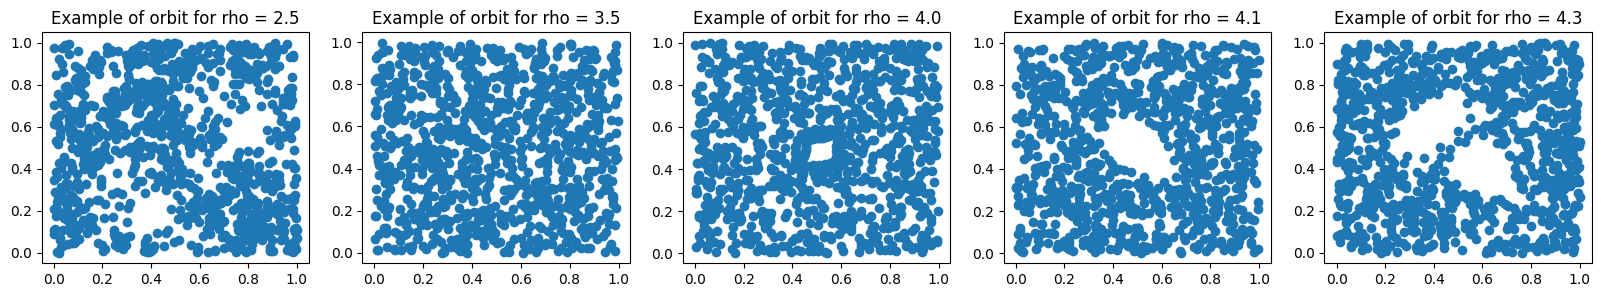

In [3]:
# Get the orbits point clouds

point_clouds = og.get_orbits()

# For each rho value, plot one point cloud

rho_values = [2.5, 3.5, 4.0, 4.1, 4.3]
fig, ax = plt.subplots(ncols=len(rho_values), figsize = (20,3))

for i in range(len(rho_values)):
    x , y = point_clouds[i*config_data.num_orbits_per_class,:,0], point_clouds[i*config_data.num_orbits_per_class,:,1] 
    ax[i].scatter(x, y)
    ax[i].set_title('Example of orbit for rho = ' + str(rho_values[i]))


## Specify the Persformer achitecture

To directly initialize the Persformer model, we wrap the Persformer class using `PersformerWrapper`.

In [4]:
# Define the model by using a Wrapper for the Persformer model

wrapped_model = PersformerWrapper(
    num_attention_layers=32,
    num_attention_heads=32,
    input_size= 2 + 2,
    output_size=5,
    pooler_type=PoolerType.ATTENTION,
    hidden_size=128,
    intermediate_size=128,
)

# Define the trainer 

writer = GiottoSummaryWriter()

loss_function =  nn.CrossEntropyLoss()

trainer = Trainer(wrapped_model, [dl_train,], loss_function, writer) 




## We are ready to train Persformer!

### Initialize the tensorboard writer

In order to analyse the results of your models, you need to start tensorboard.
On the terminal, move inside the `/examples` folder. There run the following command:

```
tensorboard --logdir=runs
```

Then go [here](http://localhost:6006/) after the training to see all the visualization results.


In [5]:
# train the model for one epoch

n_epoch = 1

trainer.train(Adam, n_epoch)

from _init_profiler: pid = 2524771, profiling = False
from train: PID=2524771, self.device=cuda
Epoch 1
-------------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.65 GiB (GPU 0; 23.70 GiB total capacity; 20.46 GiB already allocated; 1.07 GiB free; 21.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Interpretability : Saliency Maps for persistence diagrams

One of the key feature of the Persformer achitecture, is that it is proven to satisfy a Universal Approximation Theorem. The authors of the [Persformer paper](https://arxiv.org/abs/2112.15210) also give evidence that this achitecture has less inductive bias than already existing deep neural networks architecture that can input persistence diagrams. This observation motivates the introduction of importance score of points in persistence diagrams in a classification task.
 
The $\textbf{Persformer}$ model for a classification problem is an almost everywhere differentiable function $F: \mathcal D \to \mathbb{R}^m$, where $m$ is the number of classes and $\mathcal D$ is the space of persistence diagrams. It maps a persistence diagram to the logits of the class probability. Let $d$ be the maximum homology dimension to be considered and let $x = (x_k)_{k\in \{ 1,\ldots, n \}}\in (\R^{2+d})^n$ be a persistence diagram and $i(x) = \mathrm{argmax}_j F(x)_j$. The first two coordinates of $x_k \in \mathbb{R}^{2+d}$ are the birth and death coordinates and the last $d$ coordinates are the one-hot encoded homology dimensions. 

The *saliency map* of $F$ on $x$ is defined as 
$$ \mathcal{S}_F(x) :=
\left (\left\|\frac{\partial F_{i(x)}(x)}{\partial x_k}\right\|_2 \right )_{k \in \{ 1,\ldots, n \}}\in \mathbb{R}_{\geq 0}^n.
$$

Therefore, $\mathcal{S}_F$ assigns to each point in a persistence diagram, a real value indicating how important a given point in the diagram is for the classification.

With Giotto-deep, it is possible to compute saliency maps of a Persformer model with just a few lines of code. Let's do it!

In [ ]:
# Initialize the Interpreter class in Saliency mode

inter = Interpreter(trainer.model, method="Saliency")

# Get a datum and its corresponding class

batch = next(iter(dl_train))
datum = batch[0][0].reshape(1, *(batch[0][0].shape))
class_ = batch[1][0].item()

# interpret the diagram
x, attr = inter.interpret(x=datum, y=class_)

# visualise the results
vs = Visualiser(trainer)
vs.plot_attributions_persistence_diagrams(inter)
